In [1221]:
%reset -f

Install **Tensorflow** & **Tensorflow-Quantum**

In [1222]:
!pip install -q tensorflow==2.1.0

In [1223]:
!pip install -q tensorflow-quantum

Installing `Cirq` and `sympy` for defining Qunatum circuit & Quantum circuit variables respectively.

In [1224]:
import numpy as np
import sympy

# For Quantum ML
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq

# For Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Let's make a very simple binary class data

In [1225]:
def get_data(l):
    data = np.random.randint(0,1,(l,2))
    #label = np.ones(l) * -1
    label = np.ones(l)
    data[0::2,0]=1
    data[1::2,1]=1
    #label[1::2] = 1
    label[0::2] = -1
    p = np.random.permutation(l)
    return data[p], label[p]

x_train, y_train = get_data(5000)
x_test, y_test = get_data(200)

The Data!

*The cell below is just for data visulization.*

In [1226]:
import pandas as pd
print(pd.DataFrame(np.concatenate((x_train, np.reshape(y_train, (-1,1))), axis=1) , columns=["x1", "x2", "y"]))

       x1   x2    y
0     1.0  0.0 -1.0
1     1.0  0.0 -1.0
2     1.0  0.0 -1.0
3     0.0  1.0  1.0
4     1.0  0.0 -1.0
...   ...  ...  ...
4995  1.0  0.0 -1.0
4996  0.0  1.0  1.0
4997  1.0  0.0 -1.0
4998  1.0  0.0 -1.0
4999  1.0  0.0 -1.0

[5000 rows x 3 columns]


In [1227]:
def convert_to_circuit(x):
    qubits = cirq.GridQubit.rect(1, 2)
    circuit = cirq.Circuit()
    for i, val in enumerate(x):
        if val:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [1228]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

In [1229]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

Let's build a **simple classifier** on the similar line of https://arxiv.org/abs/1802.06002

*For Later: This can be furthur simplified to just 2 variables (aplha & beta), which are shared in code below*

In [1230]:
input_qubits = cirq.GridQubit.rect(2, 1)  # 2x1 grid.
readout = cirq.GridQubit(-1, -1)   # a qubit at [-1,-1]
model_circuit = cirq.Circuit()

model_circuit.append(cirq.X(readout))
model_circuit.append(cirq.H(readout))

alpha1 = sympy.Symbol('a1')
model_circuit.append(cirq.XX(input_qubits[0], readout)**alpha1)

alpha2 = sympy.Symbol('a2')
model_circuit.append(cirq.XX(input_qubits[1], readout)**alpha2)

beta1 = sympy.Symbol('b1')
model_circuit.append(cirq.ZZ(input_qubits[0], readout)**beta1)

beta2 = sympy.Symbol('b2')
model_circuit.append(cirq.ZZ(input_qubits[1], readout)**beta2)

model_circuit.append(cirq.H(readout))
model_readout = cirq.Z(readout)

Let see what we just built

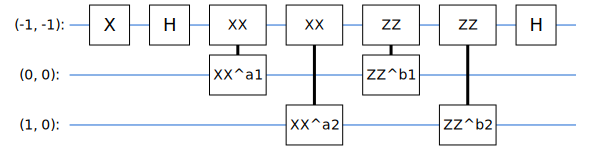

In [1231]:
SVGCircuit(model_circuit)

Let's build the **Qauntum-NN**

Read about Quantum Layers:
*   [Parametrized Quantum Circuit (PQC) Layer](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/PQC) Layer.

*   [Controlled Parametrized Quantum Circuit (PQC)](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/ControlledPQC) Layer.

In [1232]:
# Build the model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate @ [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [1233]:
def accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

In [1234]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[accuracy])

In [1235]:
print(model.summary())

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_44 (PQC)                 (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
None


In [1236]:
model_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=200,
      epochs=5,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test))

results = model.evaluate(x_test_tfcirc, y_test)

Train on 5000 samples, validate on 200 samples
Epoch 1/5
5000/5000 [==============================] - 4s 886us/sample - loss: 0.2459 - accuracy: 1.0000 - val_loss: 0.2036 - val_accuracy: 1.0000
Epoch 2/5
5000/5000 [==============================] - 4s 735us/sample - loss: 0.1728 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 1.0000
Epoch 3/5
5000/5000 [==============================] - 4s 716us/sample - loss: 0.1213 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 1.0000
Epoch 4/5
5000/5000 [==============================] - 4s 718us/sample - loss: 0.0851 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 0s 684us/sample - loss: 0.0500 - accuracy: 1.0000


Sample predictions for the test data

In [1237]:
print(list(zip(model.predict(x_test_tfcirc).ravel()[:10], y_test[:10])))

[(-0.7765335, -1.0), (0.77620333, 1.0), (0.77620333, 1.0), (0.77620333, 1.0), (-0.7765335, -1.0), (0.77620333, 1.0), (-0.7765335, -1.0), (0.77620333, 1.0), (0.77620333, 1.0), (0.77620333, 1.0)]


Training & validation Plots

RMSE :  0.05, Acc  1.00


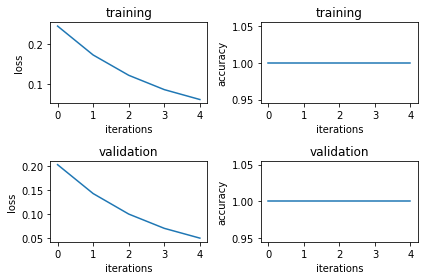

{'loss': [0.24593304753303527, 0.1727535021305084, 0.12134397745132447, 0.08505846738815308, 0.05999375268816948], 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.20355671644210815, 0.14317776262760162, 0.10030648112297058, 0.07045672088861465, 0.05001112073659897], 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0]}


In [1238]:
print("RMSE : % 5.2f, Acc % 5.2f" %(results[0], results[1]))

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(model_history.history['loss'])
axs[0, 0].set_title('training')
axs[0, 0].set(xlabel='iterations', ylabel='loss')

axs[0, 1].plot(model_history.history['accuracy'])
axs[0, 1].set_title('training')
axs[0, 1].set(xlabel='iterations', ylabel='accuracy')

axs[1, 0].plot(model_history.history['val_loss'])
axs[1, 0].set_title('validation')
axs[1, 0].set(xlabel='iterations', ylabel='loss')

axs[1, 1].plot(model_history.history['val_accuracy'])
axs[1, 1].set_title('validation')
axs[1, 1].set(xlabel='iterations', ylabel='accuracy')

plt.tight_layout()
plt.show()
print(model_history.history)

---

For building a better classifer, check various [loss functions](https://keras.io/api/losses/)

More a maximum Margin classifier, check [hinge loss](https://keras.io/api/losses/hinge_losses/)

For an imporved version of above, check  [tfq_classifier_101.ipynb](https://github.com/AbhishekAshokDubey/quantum-computing-101/blob/master/qml-101/tfq_classifier_101.ipynb)